# Electrochemical O3 sensor data preprocessing

- Pollutant: Carbon Monoxide
- Sensor: Alphasense OX-B4

## Tags description
### Based on AQMesh quality control data for their sensors

- Stabilizing (STABILIZING): Stabilisation is a period whereby a sensor provides “bad” data due to not being in a state of equilibrium. Once the sensor settles in its environment after being recently moved in a manner which may shock or destabilise the sensor or after its being first installed, it will provide usable data. This process takes 2 days to complete for electrochemical sensors, 12 hours for NDIR and is not required for the OPC. (AQMesh Standard Operation Procedure Manual)

- Rebasing (This wasn't implemented): The rebasing process standardises sensor output following the stabilisation of a sensor and is a vital stage before the start of a new project if there is any possibility that sensors have been destabilised. Sensors automatically rebase when first shipped by the manufacturer but after that, including if the pod is first switched on at a location other than the monitoring site, such as in an office, the process must be triggered manually. This will give the best possible pod-to-pod comparability and ‘out-of-the-box’ accuracy. ([AQMesh Standard Operation Procedure Manual](https://www.aqmesh.com/media/1dfhyw0h/standard-operating-procedure-v3-1.pdf)). Through this process AQMesh establishes a baseline for gas readings in a given environment –the pod is “zeroed”. The process by which this is done is complex and carried out on the cloud server. It is an important part of delivering accurate PreScaled data for ppb gas levels and needs to be completed in or near the intended measurement location (similar gas levels and environmental conditions). Rebasing the sensors directly affects the baseline of the sensor outputs, as such the offset between AQMesh and the reference instrument can differ before and after the rebasing process. ([AQMesh Rebasing Guidance](https://www.aqmesh.com/media/rdbf1ex0/rebasing-guidance.pdf))

- Greater than upper limit (GTUL): didn't find any specification about this yet but I guess it should be related to sensor manufacturer specification or known values for the pollutant. In this case I used the sensor's range as the UPPER LIMIT. For example:
  - Alphasense CO-B4: 1.000 ppm = 1.000.000 ppb
  - SPEC DGS-CO:  1.000 ppm = 1.000.000 ppb

- Less than lower limit (LTLL): similar to the previous, maybe related to negative values

- Valid (VALID): valid data

- N/A: suppose it's equivalent to NaN

### Based on the data quality control tags used by Ottosen & Kumar 2019:

- Error (ERROR): The erroneous measurements are seen as abrupt changes in the mean and/or the variance of the time series and have to be removed as part of the quality control. To detect these points, the Pruned Exact Linear Time (PELT) algorithm ([Killick, Fearnhead and Eckley 2011](https://doi.org/10.1080/01621459.2012.737745)), which is one of the commonly applied methods for change detection in time series, was used.

### Based on the Air Quality Monitoring Guide (IMA)

- Minimum number of samples for calculating the horly average (LOWSMPLES): at least 3/4 of the measurments of an hour must be valid

## Constants

### Sensors IDs

### API Constants

In [17]:
HOST = "renovar.lcqar.ufsc.br"
PORT = 8080
RAW_DATA_DIR = "data/raw-data-monit-fix-2022-2023-Diamante/"
RAW_FILE_NAME = "ISB_O32.CSV"

SENSOR_FILE_DIR = 'data/input/'
SENSOR_NAME = 'alpha_o3_2_conc'
SENSOR_FILE_NAME = SENSOR_NAME + 'web_dataframe.csv'

### Sensor Constants

In [18]:
M = 48
lower_limit=15.0
upper_limit=20e3
t_90 = 80     # sensor takes 30 seconds to reach a value of 10e3
t_90_value = 1e3
sampling_period = 15 * 60

# Alphasense O3 (2) Sensor Data

In [19]:
from GetSensorDataService import GetSensorDataService

get_sensor_data_service = GetSensorDataService(HOST, PORT)
sensor_data = get_sensor_data_service.get_data_from_file(RAW_DATA_DIR+RAW_FILE_NAME, sensor_name=SENSOR_NAME)
sensor_data.head()

/Users/Fernando/Documents/Projects/Github/lcqar-low-cost-monit-proc/data-pre-processing/GetSensorDataService.py:13: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['DateTime'] = (pd.to_datetime(df[date_time_col], infer_datetime_format=False, format='%d/%m/%Y/%H/%M/%S'))


,latitude,longitude,measuring,DateTime
0,-28.456899,-48.972999,27.48,2022-11-21 10:41:59
1,-28.456899,-48.972999,27.61,2022-11-21 10:57:45
2,-28.456899,-48.972999,27.92,2022-11-21 11:13:34
3,-28.456899,-48.972999,28.17,2022-11-21 11:29:19
4,-28.456899,-48.972999,28.34,2022-11-21 11:45:05


## Upload Data from File

In [20]:
import pandas as pd

df = pd.read_csv(SENSOR_FILE_DIR + SENSOR_FILE_NAME)
df.head()

,Unnamed: 0,latitude,longitude,measuring,DateTime
0,0,-28.456899,-48.972999,27.48,2022-11-21 10:41:59
1,1,-28.456899,-48.972999,27.61,2022-11-21 10:57:45
2,2,-28.456899,-48.972999,27.92,2022-11-21 11:13:34
3,3,-28.456899,-48.972999,28.17,2022-11-21 11:29:19
4,4,-28.456899,-48.972999,28.34,2022-11-21 11:45:05


### Create Sensor Dataframe as Pandas Series with a period of 15 mins

In [21]:
# Remove the first column with the indexes and save data into web dataframe
web_dataframe = df.drop(df.columns[0], axis='columns')
web_dataframe['DateTime'] = (pd.to_datetime(df['DateTime'], infer_datetime_format=True))

# Resample data with 15 mins period and create sensor dataframe
sensor_dataframe = web_dataframe.sort_values(by='DateTime', ascending=True).reset_index().drop(columns='index')
sensor_dataframe.index = sensor_dataframe['DateTime']
sensor_dataframe = sensor_dataframe.drop(columns=['DateTime'])
sensor_dataframe = sensor_dataframe.resample('15T').mean()
sensor_dataframe.head()

/var/folders/wc/_83zcrx913j1dqwg4g90kbhh0000gp/T/ipykernel_4644/2771449038.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  web_dataframe['DateTime'] = (pd.to_datetime(df['DateTime'], infer_datetime_format=True))


,latitude,longitude,measuring
DateTime,,,
2022-11-21 10:30:00,-28.456899,-48.972999,27.48
2022-11-21 10:45:00,-28.456899,-48.972999,27.61
2022-11-21 11:00:00,-28.456899,-48.972999,27.92
2022-11-21 11:15:00,-28.456899,-48.972999,28.17
2022-11-21 11:30:00,NaN,NaN,NaN


### Plot raw data

<Axes: xlabel='DateTime'>

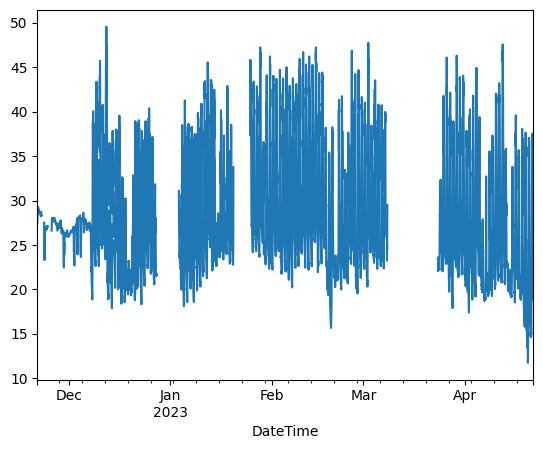

In [22]:
sensor_dataframe['measuring'].plot()

### Smooth data with a window of 4 samples, i.e.: an hour of data

<Axes: xlabel='DateTime'>

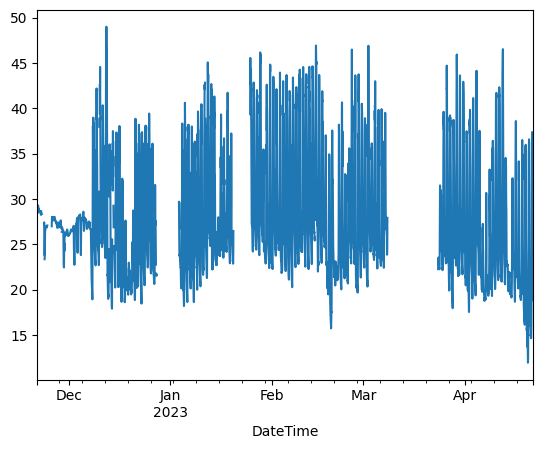

In [23]:
sensor_dataframe['raw measuring'] = sensor_dataframe['measuring']
sensor_dataframe['measuring'] = sensor_dataframe['measuring'].rolling(window=4).median()
sensor_dataframe['Hour'] = sensor_dataframe.index.hour
sensor_dataframe['measuring'].plot()

### Remove rebased data

<Axes: xlabel='DateTime'>

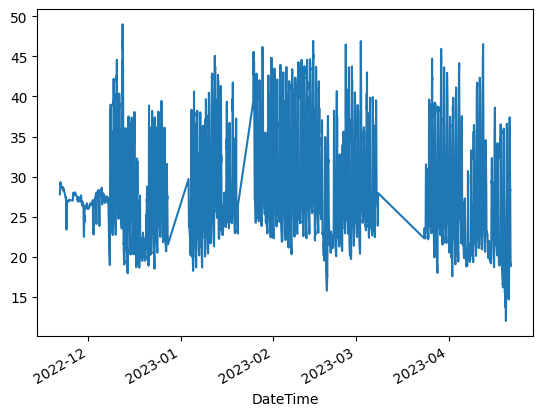

In [24]:
sensor_dataframe = sensor_dataframe[sensor_dataframe['measuring'] < 105]
sensor_dataframe['measuring'].plot()

### Convert to ug/m3

In [25]:
sensor_dataframe['value'] = sensor_dataframe['measuring'].map(lambda v: 0.0409*v*M)

## Tag data
Apply tags to the data according to the quality control processes described above

In [26]:
sensor_dataframe['Tag'] = 'VALID'

#### Tag data during stabilizing period
AQMesh recomends to considering the first two days after installation as a period for stabilization. In our case, a period of seven days was selected in order to remove outliers candidates detected during that period. For that purpose we detect the first 7 days of uninterrupted measurements

,latitude,longitude,measuring,raw measuring,Hour,value,Tag
DateTime,,,,,,,
2022-11-21 11:15:00,-28.456899,-48.972999,27.765,28.17,11,54.508248,STABILIZING
2022-11-21 12:30:00,-28.456899,-48.972999,28.510,28.69,12,55.970832,STABILIZING
2022-11-21 12:45:00,-28.456899,-48.972999,28.625,28.75,12,56.196600,STABILIZING
2022-11-21 13:00:00,-28.456899,-48.972999,28.720,28.83,13,56.383104,STABILIZING
2022-11-21 13:15:00,-28.456899,-48.972999,28.790,28.92,13,56.520528,STABILIZING


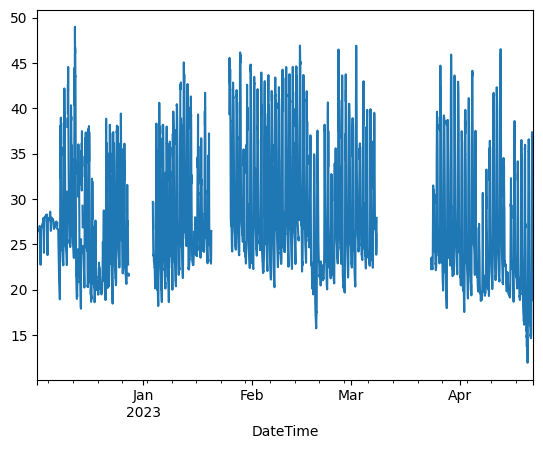

In [27]:
# Identify consecutive measurements (15 mins between each)
consecutive_periods = sensor_dataframe.index.to_series().diff().dt.seconds == 900

# Select the first seven days of consecutive measurements (96 = 24 * 60 mins / 15 mins, amount of 15 mins periods in a day)
last_stabilizing_index = sensor_dataframe[consecutive_periods].head(96 * 7).index[-1] # 7 days
sensor_dataframe.loc[sensor_dataframe.index[0]:last_stabilizing_index,'Tag'] = 'STABILIZING'
sensor_dataframe[sensor_dataframe['Tag'] == 'VALID']['measuring'].resample('15T').mean().plot()
sensor_dataframe.head()

#### Tag values that are missing, are greater than sensor span or are lower than sensor resolution

The upper limit was too high that affected the graph resolution, therefore it is not plotted

<Axes: xlabel='DateTime'>

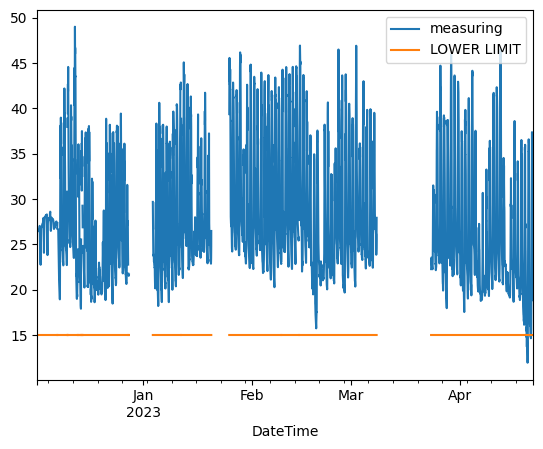

In [28]:
sensor_dataframe['UPPER LIMIT'] = upper_limit
sensor_dataframe['LOWER LIMIT'] = lower_limit
sensor_dataframe[sensor_dataframe['Tag'] == 'VALID'][['measuring', 'LOWER LIMIT']].resample('15T').mean().plot()

In [29]:
import numpy as np
from SensorDataAnalysisService import SensorDataAnalysisService as sensor_analysis

def tag_by_sensor_limits(value, tag, lower_limit, upper_limit):
 if (tag != 'VALID'): return tag
 return sensor_analysis.get_tags_from_series(value=value,
                                             lower_limit=lower_limit,
                                             upper_limit=upper_limit)

sensor_dataframe['Tag'] = (sensor_dataframe[['measuring', 'Tag']]
                                        .apply(lambda df: tag_by_sensor_limits(value=df[0], tag=df[1],
                                                                              lower_limit=lower_limit,
                                                                              upper_limit=upper_limit),
                                                axis=1))

#### Plot valid data after removing samples bellow lower limit

<Axes: xlabel='DateTime'>

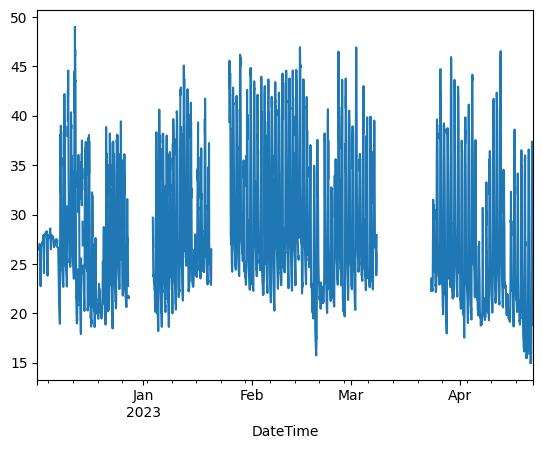

In [30]:
sensor_dataframe[sensor_dataframe['Tag'] == 'VALID']['measuring'].resample('15T').mean().plot()

#### Tag values with derivatives faster than sensor response time
The value of 1000 ppb was selected based on the maximum derivative found in the reference data. The maximum derivative (with measuring period of 1 hour) found was 27 ppb. Therefore, a maximum of 1000 ppb was considered appropriate for a 15 mins period.

<Axes: xlabel='DateTime'>

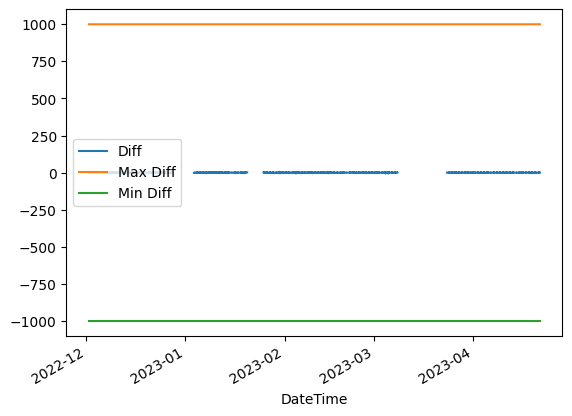

In [31]:
max_diff_value = 1000
sensor_dataframe['Diff'] = sensor_dataframe['measuring'].resample('15T').mean().diff()
sensor_dataframe['Max Diff'] = max_diff_value
sensor_dataframe['Min Diff'] = -max_diff_value
sensor_dataframe[sensor_dataframe['Tag'] == 'VALID'][['Diff', 'Max Diff', 'Min Diff']].plot()

In [32]:
import numpy as np

def tag_data_with_derivatives(tagged_df, max_diff_value):
        current_tag = tagged_df[0]
        value = tagged_df[1]
        if ((current_tag != 'VALID') or (np.isnan(value))): return current_tag
        if ((value > max_diff_value) or (value < -max_diff_value)): return 'BADSPIKE'
        return 'VALID'

sensor_dataframe['Tag'] = (sensor_dataframe[['Tag', 'Diff', 'Max Diff']]
                           .apply(lambda df: tag_data_with_derivatives(tagged_df=df, max_diff_value=df[2]),
                                   axis=1))

### Data Tag contabilization

In [33]:
tags = ['MISSING','LTLL', 'GTUL', 'STABILIZING', 'BADSPIKE', 'VALID']
data_contabilization = sensor_analysis.count_tags(tags, sensor_dataframe)
data_contabilization

,#,%
MISSING,0,0.0
LTLL,49,0.425495
GTUL,0,0.0
STABILIZING,697,6.052449
BADSPIKE,0,0.0
VALID,10770,93.522056
TOTAL,11516,100.0


## Analyse valid data

The graph shows the time series of the valid data, box plots of the data grouped by hour of the day, and histogram of the data.

In [34]:
valid_dataframe = sensor_dataframe[sensor_dataframe['Tag'] == 'VALID'].drop(columns=['Tag'])

### Smooth data with a window of 4 samples, i.e.: an hour of data

<Axes: xlabel='DateTime'>

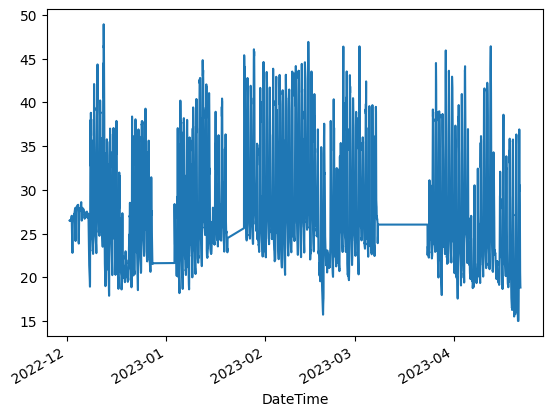

In [35]:
valid_dataframe['raw measuring'] = valid_dataframe['measuring']
valid_dataframe['measuring'] = valid_dataframe['measuring'].rolling(window=4).median()
valid_dataframe['measuring'].plot()

### Analyse data

/Users/Fernando/Documents/Projects/Github/lcqar-low-cost-monit-proc/data-pre-processing/SensorDataAnalysisService.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hour'] = df['Hour'].astype('int64')


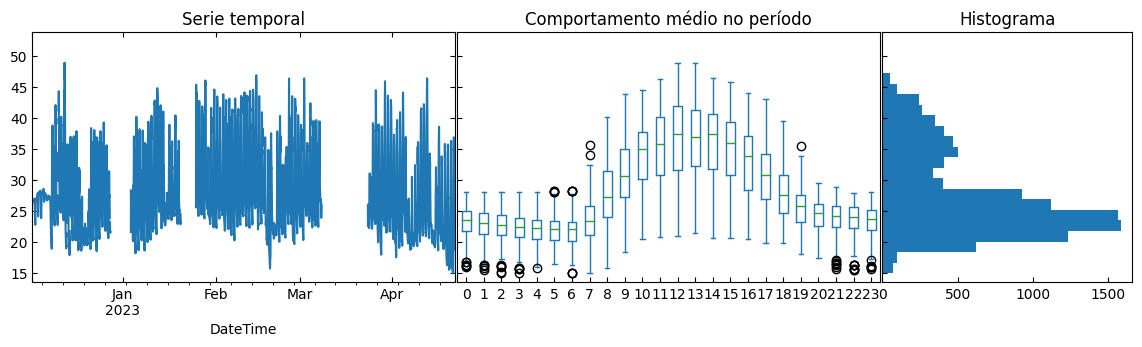

In [36]:
valid_dataframe = valid_dataframe.resample('15T').mean()
sensor_analysis.plot_box_hist(df=valid_dataframe, bins=20)

### Calculate quantiles

We calculated the 1% and 99 % quantiles of every hour of the day. The values greater outside the 1 % - 99 % where tagged as Greater that Quantile 99 (GTQTLE99) and Lower than Quantile 1 (LTQTLE01)

<Axes: xlabel='DateTime'>

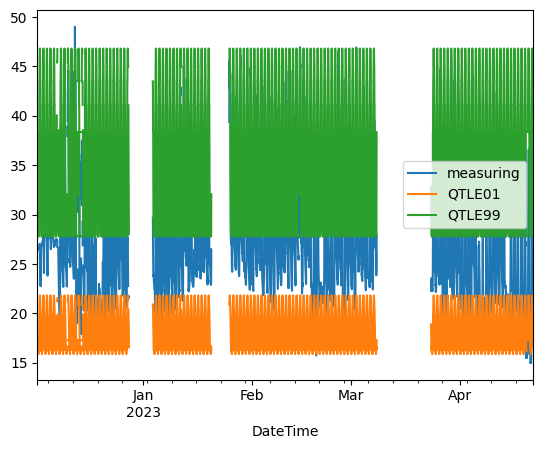

In [37]:
import numpy as np

global_qtle_01 = valid_dataframe.pivot(columns='Hour')['measuring'].quantile(q=0.01, axis='index', interpolation='lower').dropna()
global_qtle_99 = valid_dataframe.pivot(columns='Hour')['measuring'].quantile(q=0.99, axis='index', interpolation='higher').dropna()
sensor_dataframe['QTLE01'] = sensor_dataframe['Hour'].map(lambda hr: global_qtle_01[hr] if (not np.isnan(hr)) else np.nan)
sensor_dataframe['QTLE99'] = sensor_dataframe['Hour'].map(lambda hr: global_qtle_99[hr] if (not np.isnan(hr)) else np.nan)
sensor_dataframe[sensor_dataframe['Tag'] == 'VALID'][['measuring', 'QTLE01', 'QTLE99']].resample('15T').mean().plot()

### Tag data according to quantiles

In [38]:
sensor_dataframe['Tag'] = (sensor_dataframe[['Tag', 'measuring', 'QTLE01', 'QTLE99']]
                           .apply(lambda df: sensor_analysis.tag_by_quantiles(current_tag=df[0],
                                                                              value=df[1],
                                                                              quantile_01=df[2],
                                                                              quantile_99=df[3]),
                                axis=1))
tags = ['MISSING','LTLL', 'GTUL', 'BADSPIKE', 'VALID', 'LTQTLE01', 'GTQTLE99']
data_contabilization = sensor_analysis.count_tags(tags, sensor_dataframe)
data_contabilization

,#,%
MISSING,0,0.0
LTLL,49,0.425495
GTUL,0,0.0
BADSPIKE,0,0.0
VALID,10498,91.160125
LTQTLE01,125,1.085446
GTQTLE99,147,1.276485
TOTAL,11516,100.0


#### Plot valid data

<Axes: xlabel='DateTime'>

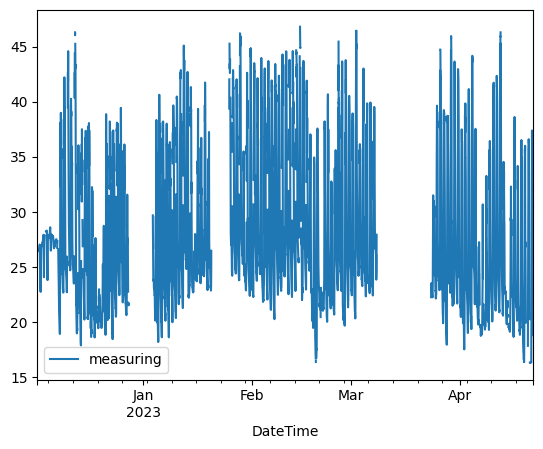

In [39]:
sensor_dataframe[sensor_dataframe['Tag'] == 'VALID'][['measuring']].resample('15T').mean().plot()

#### Analyse data after removing quantiles

/Users/Fernando/Documents/Projects/Github/lcqar-low-cost-monit-proc/data-pre-processing/SensorDataAnalysisService.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hour'] = df['Hour'].astype('int64')


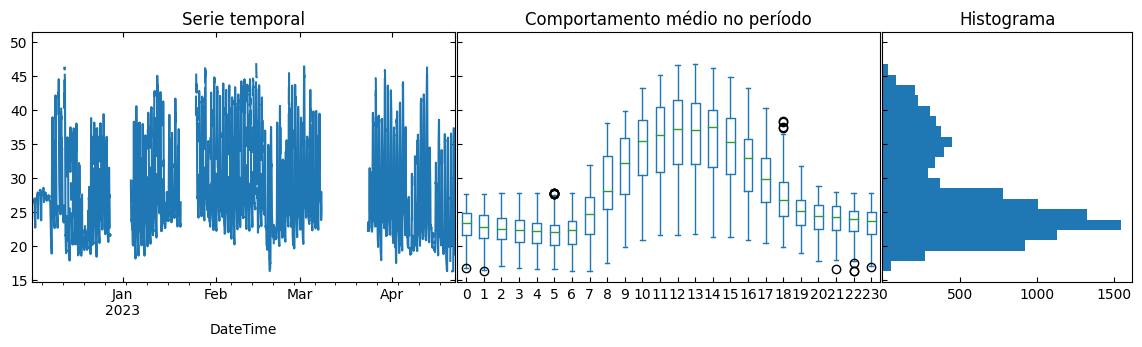

In [40]:
valid_dataframe = sensor_dataframe[sensor_dataframe['Tag'] == 'VALID'].drop(columns=['Tag']).resample('15T').mean()
sensor_analysis.plot_box_hist(df=valid_dataframe, bins=20)

## Analyse data derivatives

Analyse the derivatives of the data for removing abrupt changes in the data (BADSPIKE)

<Axes: xlabel='DateTime'>

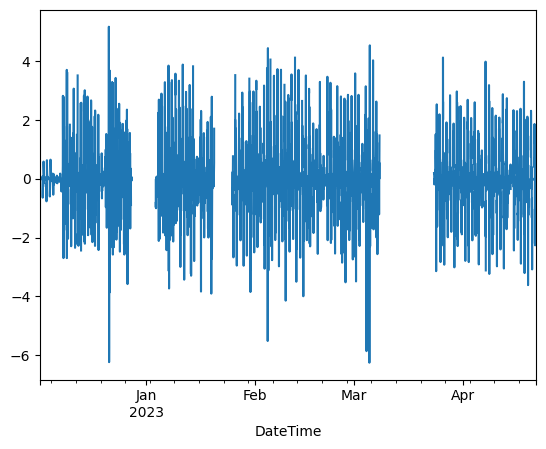

In [41]:
sensor_dataframe[sensor_dataframe['Tag'] == 'VALID']['Diff'].resample('15T').mean().plot()

#### Plot data derivatives vs data

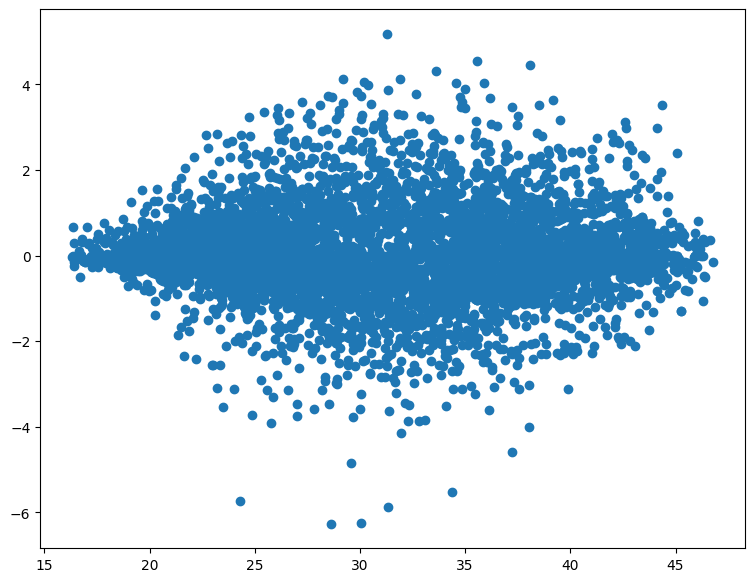

In [42]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(1.3*7,7))
plt.scatter(valid_dataframe['measuring'], valid_dataframe['Diff'])

### Calculate quantiles of the derivatives

<Axes: xlabel='DateTime'>

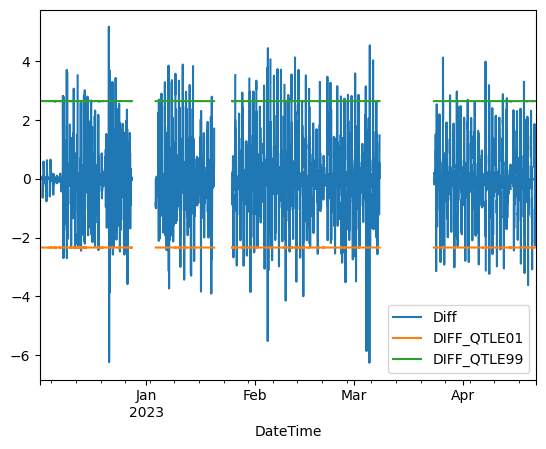

In [43]:
import numpy as np

global_qtle_01 = valid_dataframe['Diff'].quantile(q=0.01, interpolation='lower')
global_qtle_99 = valid_dataframe['Diff'].quantile(q=0.99, interpolation='higher')
sensor_dataframe['DIFF_QTLE01'] = global_qtle_01
sensor_dataframe['DIFF_QTLE99'] = global_qtle_99
sensor_dataframe[sensor_dataframe['Tag'] == 'VALID'][['Diff', 'DIFF_QTLE01', 'DIFF_QTLE99']].resample('15T').mean().plot()

### Tag data according to the quantiles of the derivatives

In [44]:
def tag_by_diff_quantiles(current_tag, value, quantile_01, quantile_99):
    if ((current_tag != 'VALID') or (np.isnan(value))): return current_tag
    if value <= quantile_01 or value >= quantile_99: return 'BADSPIKE'
    return 'VALID'

sensor_dataframe['Tag'] = (sensor_dataframe[['Tag', 'Diff', 'DIFF_QTLE01', 'DIFF_QTLE99']]
                           .apply(lambda df: tag_by_diff_quantiles(current_tag=df[0],
                                                                    value=df[1],
                                                                    quantile_01=df[2],
                                                                    quantile_99=df[3]),
                                    axis=1))
tags = ['MISSING','LTLL', 'GTUL', 'BADSPIKE', 'VALID', 'LTQTLE01', 'GTQTLE99']
data_contabilization = sensor_analysis.count_tags(tags, sensor_dataframe)
data_contabilization

,#,%
MISSING,0,0.0
LTLL,49,0.425495
GTUL,0,0.0
BADSPIKE,210,1.82355
VALID,10288,89.336575
LTQTLE01,125,1.085446
GTQTLE99,147,1.276485
TOTAL,11516,100.0


#### Plot valid data

<Axes: xlabel='DateTime'>

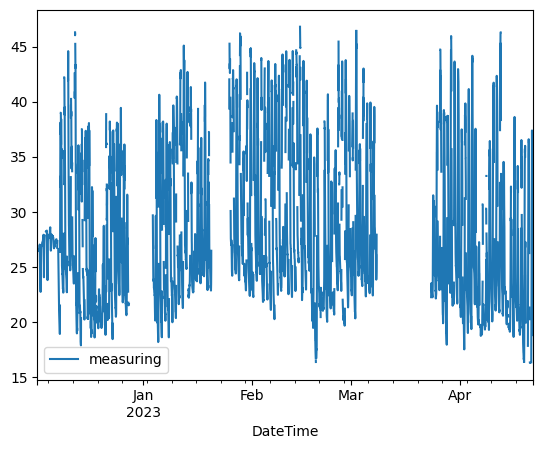

In [45]:
sensor_dataframe[sensor_dataframe['Tag'] == 'VALID'][['measuring']].resample('15T').mean().plot()

/Users/Fernando/Documents/Projects/Github/lcqar-low-cost-monit-proc/data-pre-processing/SensorDataAnalysisService.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hour'] = df['Hour'].astype('int64')


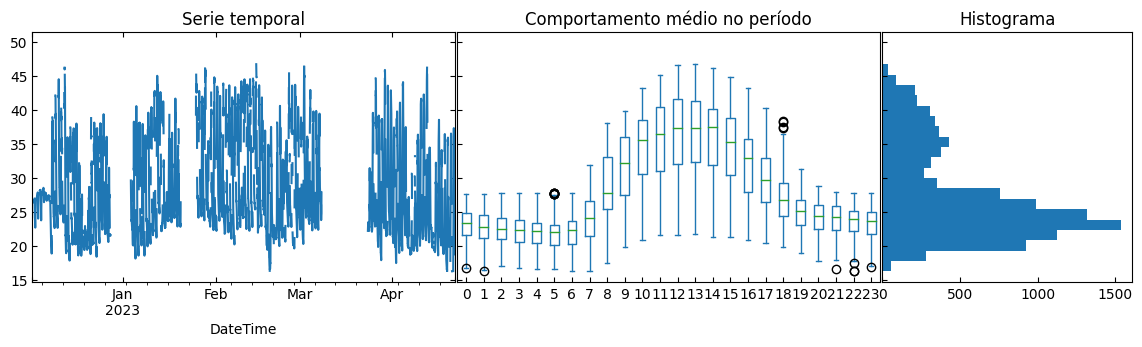

In [46]:
valid_dataframe = sensor_dataframe[sensor_dataframe['Tag'] == 'VALID'].drop(columns=['Tag']).resample('15T').mean()
sensor_analysis.plot_box_hist(df=valid_dataframe, bins=20)

## Resample valid data to 1 HR

<Axes: xlabel='DateTime'>

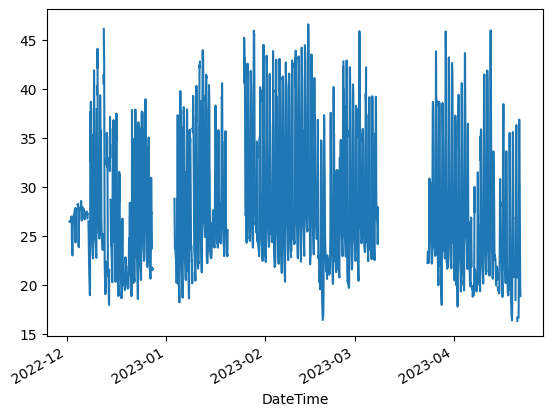

In [47]:
resampled_dataframe = sensor_dataframe[sensor_dataframe['Tag'] == 'VALID'].drop(columns=['Tag']).resample('H').mean()
resampled_dataframe['Hour'] = resampled_dataframe.index.hour
resampled_dataframe['Count'] = (valid_dataframe['measuring'].resample('H').count())
resampled_dataframe['Std'] = (valid_dataframe['measuring'].resample('H').std())
resampled_dataframe.index = resampled_dataframe.index.map(lambda t: t.replace(minute=30, second=0))
resampled_dataframe['measuring'].plot()

#### Tag hourly data according to the number of samples in an hour
At least 3 samples must be valid in an hour (75 %) for the hourly data be considered as valid

<Axes: xlabel='DateTime'>

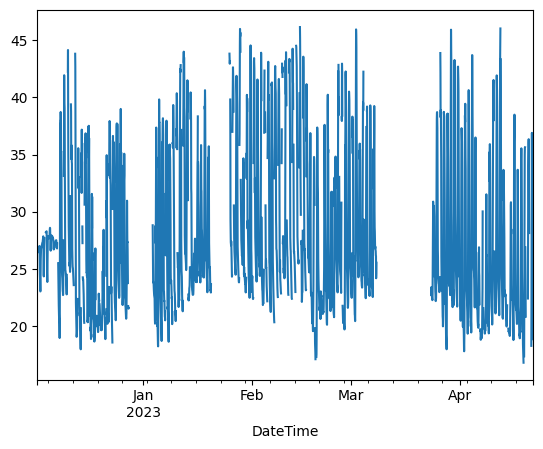

In [48]:
resampled_dataframe['Tag'] = (resampled_dataframe['Count']
                                .map(lambda c: 'VALID' if c >= 3 else 'LOWSAMPLES'))
resampled_dataframe[resampled_dataframe['Tag'] == 'VALID']['measuring'].resample('H').mean().plot()

#### Valid data contabilization

In [49]:
tags = ['LOWSAMPLES','VALID'] 
data_contabilization = sensor_analysis.count_tags(tags, resampled_dataframe)
data_contabilization

,#,%
LOWSAMPLES,824,24.335499
VALID,2562,75.664501
TOTAL,3386,100.0


# Save Data

In [50]:
import os

output_directory_path = 'data/output/'
processing_directory_path = '../data-processing/input/'
valid_1HR_filename = '_valid_data_1HR.csv'
valid_filename = '_valid_data.csv'
dataframe_filename = '_dataframe.csv'
dataframe_1HR_filename = '_dataframe_1hr.csv'

valid_1HR_file_path_output = output_directory_path + SENSOR_NAME + valid_1HR_filename
valid_file_path_output = output_directory_path + SENSOR_NAME + valid_filename

dataframe_path_1HR_output = output_directory_path + SENSOR_NAME + dataframe_1HR_filename
dataframe_path_output = output_directory_path + SENSOR_NAME + dataframe_filename

valid_processing_1HR_file_path = processing_directory_path + SENSOR_NAME + valid_1HR_filename
valid_processing_file_path = processing_directory_path + SENSOR_NAME + valid_filename

processing_dataframe_path_1HR = processing_directory_path + SENSOR_NAME + dataframe_1HR_filename
processing_dataframe_path = processing_directory_path + SENSOR_NAME + dataframe_filename

if not os.path.exists(output_directory_path):
    os.makedirs(output_directory_path)

if not os.path.exists(processing_directory_path):
    os.makedirs(processing_directory_path)

sensor_dataframe[sensor_dataframe['Tag'] == 'VALID'][['measuring', 'value']].to_csv(valid_file_path_output)
resampled_dataframe[resampled_dataframe['Tag'] == 'VALID'][['measuring', 'value']].to_csv(valid_1HR_file_path_output)
sensor_dataframe.to_csv(dataframe_path_output)
resampled_dataframe.to_csv(dataframe_path_1HR_output)

sensor_dataframe[sensor_dataframe['Tag'] == 'VALID'][['measuring', 'value']].to_csv(valid_processing_file_path)
resampled_dataframe[resampled_dataframe['Tag'] == 'VALID'][['measuring', 'value']].to_csv(valid_processing_1HR_file_path)
sensor_dataframe.to_csv(processing_dataframe_path)
resampled_dataframe.to_csv(processing_dataframe_path_1HR)